In [ ]:
import os
import sys
sys.path.append('..')

from IPython.display import clear_output

import glob
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
np.seterr(divide='ignore', invalid='ignore')

from uncertain.implicit import logMF, CAMF
from uncertain.BPR import bprMF, biasMF, TwoWayMF, bprGMF, bprMLP, ABPR, GPR
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

from uncertain.utils.data import ImplicitData as Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation_implicit import test

from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import seaborn as sns

os.chdir('ML_implicit')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = Data(data)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)
        
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim':1, 'lr':0, 'weight_decay':0}

# logMF

In [2]:
name = 'logMF'
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 0, 0),
              'n_negative': trial.suggest_int('neg', 5, 50)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(name, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(name, **base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8127779556694062, 'Rating_rec': {'MAP': array([0.08916142, 0.11932383, 0.13457077, 0.14367657, 0.1493631 ,
       0.15249259, 0.15404033, 0.15520843, 0.15564271, 0.15611394]), 'Recall': array([0.00808123, 0.01552509, 0.02207175, 0.02879102, 0.03485317,
       0.0404854 , 0.04566043, 0.05164393, 0.05641652, 0.06138174])}}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_wd,user_attrs_filename,state
1,1,0.144092,2022-04-05 18:27:45.937101,2022-04-05 18:32:32.508123,0 days 00:04:46.571022,237,132,0.000356,37,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
7,7,0.142932,2022-04-05 18:41:28.112658,2022-04-05 18:44:47.853001,0 days 00:03:19.740343,6223,88,0.000928,15,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
11,11,0.142485,2022-04-05 18:54:18.771877,2022-04-05 18:57:17.714246,0 days 00:02:58.942369,7070,50,0.000914,5,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
26,26,0.142365,2022-04-05 19:28:09.261305,2022-04-05 19:33:49.923717,0 days 00:05:40.662412,6641,102,0.000491,16,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
8,8,0.142260,2022-04-05 18:44:47.854004,2022-04-05 18:49:40.839722,0 days 00:04:52.985718,3194,136,0.000365,19,0.0,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE


# BPR

In [3]:
name = 'bprMF'
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(name, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(name, **base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8102429999644217, 'Rating_rec': {'MAP': array([0.09545907, 0.12976467, 0.14510828, 0.15324734, 0.15781129,
       0.16062281, 0.16155376, 0.16206824, 0.16269045, 0.162702  ]), 'Recall': array([0.00743634, 0.01509579, 0.02121003, 0.02740454, 0.03269746,
       0.03787159, 0.0428524 , 0.04734675, 0.05150037, 0.05601986])}}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
1,1,0.144377,2022-04-06 09:56:18.080324,2022-04-06 09:58:22.530510,0 days 00:02:04.450186,3602,196,0.000498,6.725547e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
39,39,0.143950,2022-04-06 12:39:05.738445,2022-04-06 12:41:11.003739,0 days 00:02:05.265294,2369,88,0.000723,7.903844e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
7,7,0.143679,2022-04-06 10:17:23.928577,2022-04-06 10:22:30.354012,0 days 00:05:06.425435,3452,169,0.000412,4.464403e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
37,37,0.143638,2022-04-06 12:34:15.184559,2022-04-06 12:36:49.584674,0 days 00:02:34.400115,2650,94,0.000584,7.405599e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
21,21,0.143251,2022-04-06 11:20:24.935603,2022-04-06 11:26:56.920914,0 days 00:06:31.985311,4500,177,0.000384,4.384670e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE


# GPRMF (log)

In [4]:
name = 'biasGPRlog'
def init_model(**kwargs):
    return biasMF(data.n_user, data.n_item, loss=GPR(log_scale=True), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8120574945743053, 'Concordant uncertainty': 1.3055164, 'Discordant uncertainty': 1.3214008, 'corr_usup': 0.2047274568186092, 'corr_udiv': 0.2132665472204388, 'corr_isup': -0.13782493553358421, 'Rating_rec': {'MAP': array([0.09529334, 0.12852171, 0.14400343, 0.15275476, 0.15762807,
       0.15990319, 0.16121425, 0.1621919 , 0.16317659, 0.16350046]), 'Recall': array([0.00768246, 0.01502747, 0.02220244, 0.02830711, 0.03350003,
       0.03819511, 0.04280703, 0.04723014, 0.0524898 , 0.05700395]), 'URI_global': array([-0.68626615, -0.6710428 , -0.63865357, -0.63044695, -0.62578622,
       -0.61584794, -0.61333944, -0.61445599, -0.60849272, -0.60086099]), 'Unc_MAP_corr': 0.06237278462593658, 'URI': array([       nan, 0.00307403, 0.0307054 , 0.04147893, 0.02581048,
       0.03412371, 0.04256007, 0.03504071, 0.02128954, 0.00764344])}, 'Cuts': {'Values': array([1.40872943, 1.34899135, 1.29460588, 1.23181021]), 'Given': array([60340., 60340., 60340., 60340., 60177.]), 'Hits': array([448

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
29,29,0.145988,2022-04-06 14:52:41.732702,2022-04-06 14:55:44.601496,0 days 00:03:02.868794,5296,86,0.000877,4.115136e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
15,15,0.145326,2022-04-06 14:10:50.956865,2022-04-06 14:13:47.389471,0 days 00:02:56.432606,9613,105,0.000808,7.948563e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
35,35,0.143978,2022-04-06 15:10:55.375770,2022-04-06 15:13:24.286095,0 days 00:02:28.910325,3205,127,0.000651,4.227645e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
24,24,0.143878,2022-04-06 14:37:07.151727,2022-04-06 14:39:35.211348,0 days 00:02:28.059621,7022,145,0.000831,7.576447e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
28,28,0.143010,2022-04-06 14:49:23.169508,2022-04-06 14:52:41.731720,0 days 00:03:18.562212,6758,91,0.000868,4.347484e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE


# GPRMF (normal)

In [5]:
name = 'biasGPR'
def init_model(**kwargs):
    return biasMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8084018216102751, 'Concordant uncertainty': 0.2174204, 'Discordant uncertainty': 0.22976853, 'corr_usup': -0.2636383202946783, 'corr_udiv': -0.18974550565966547, 'corr_isup': -0.4817394780626273, 'Rating_rec': {'MAP': array([0.09297315, 0.1269473 , 0.14316098, 0.15185247, 0.15724644,
       0.16004281, 0.16216926, 0.16352865, 0.16373474, 0.16418622]), 'Recall': array([0.00746088, 0.01507975, 0.02193554, 0.02749602, 0.03319254,
       0.03904253, 0.04450106, 0.0495946 , 0.05417241, 0.05953835]), 'URI_global': array([-0.70795679, -0.66424211, -0.61440982, -0.5696153 , -0.52845699,
       -0.4976561 , -0.4721437 , -0.45643659, -0.43510429, -0.42254877]), 'Unc_MAP_corr': -0.14910139244169468, 'URI': array([        nan, -0.0319255 , -0.05595329, -0.03642067, -0.01537545,
       -0.03211687, -0.02613267, -0.02877609, -0.03828786, -0.04243789])}, 'Cuts': {'Values': array([0.39854898, 0.32839283, 0.26953192, 0.22720428]), 'Given': array([60340., 60340., 60340., 60340., 60339.]), 'Hit

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
33,33,0.148294,2022-04-06 22:45:25.185947,2022-04-06 22:49:50.920208,0 days 00:04:25.734261,2841,89,0.000719,7.276293e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
19,19,0.147989,2022-04-06 21:55:19.895485,2022-04-06 21:59:48.711848,0 days 00:04:28.816363,5061,64,0.000997,7.696563e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
22,22,0.147984,2022-04-06 22:04:59.425701,2022-04-06 22:08:22.753248,0 days 00:03:23.327547,3786,91,0.000999,5.339129e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
35,35,0.147654,2022-04-06 22:53:06.905533,2022-04-06 22:56:44.305523,0 days 00:03:37.399990,2895,88,0.000759,6.713930e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
29,29,0.147278,2022-04-06 22:29:17.959181,2022-04-06 22:33:17.009382,0 days 00:03:59.050201,5324,103,0.000886,6.022067e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE


# TwoWayMF

In [6]:
name = 'TwoWayMF'
def init_model(**kwargs):
    return TwoWayMF(data.n_user, data.n_item, loss=GPR(log_scale=True), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.7843953463550005, 'Concordant uncertainty': 0.69054633, 'Discordant uncertainty': 0.691863, 'corr_usup': -0.5094353709740538, 'corr_udiv': -0.08084115717608449, 'corr_isup': -0.4897471293847781, 'Rating_rec': {'MAP': array([0.08468677, 0.11078886, 0.12424042, 0.13196516, 0.13598659,
       0.1391059 , 0.13961954, 0.14069549, 0.14144974, 0.14104557]), 'Recall': array([0.0054077 , 0.01051589, 0.01516272, 0.01954293, 0.02354958,
       0.02795482, 0.03277466, 0.03690228, 0.04134693, 0.04525968]), 'URI_global': array([2.67223234, 2.49510022, 2.43461372, 2.40488726, 2.36953815,
       2.33306485, 2.27871188, 2.23161222, 2.1888218 , 2.16001291]), 'Unc_MAP_corr': -0.324213348671296, 'URI': array([       nan, 0.08829897, 0.08735463, 0.0653213 , 0.07150985,
       0.05052227, 0.04824025, 0.05153159, 0.05268811, 0.0528312 ])}, 'Cuts': {'Values': array([0.69306928, 0.69291407, 0.69264078, 0.69210446]), 'Given': array([60340., 58076., 55472., 51437., 45101.]), 'Hits': array([4095., 4060.

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
14,14,0.133237,2022-04-07 22:52:48.220259,2022-04-07 22:53:45.123554,0 days 00:00:56.903295,9721,167,0.000223,7.060339e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
8,8,0.131163,2022-04-07 22:28:52.859977,2022-04-07 22:35:58.544908,0 days 00:07:05.684931,9416,122,0.000011,8.242527e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
41,41,0.130581,2022-04-07 23:31:58.639397,2022-04-07 23:32:59.381245,0 days 00:01:00.741848,7621,139,0.000227,7.512192e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
31,31,0.129917,2022-04-07 23:11:11.880126,2022-04-07 23:19:33.365761,0 days 00:08:21.485635,7575,57,0.000011,9.446623e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
37,37,0.129625,2022-04-07 23:24:32.737871,2022-04-07 23:28:00.650142,0 days 00:03:27.912271,7231,106,0.000017,6.747694e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE


# GMF

In [7]:
name = 'GMF'
def init_model(**kwargs):
    return bprGMF(data.n_user, data.n_item, loss=GPR(log_scale=True), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=0)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8088109723556409, 'Concordant uncertainty': 0.82228845, 'Discordant uncertainty': 0.6370271, 'corr_usup': -0.03158880607933559, 'corr_udiv': 0.07040442626216553, 'corr_isup': 0.8040679564892859, 'Rating_rec': {'MAP': array([0.08501823, 0.11741796, 0.13233344, 0.14188119, 0.14762526,
       0.15107709, 0.15306561, 0.15408026, 0.1549294 , 0.15471642]), 'Recall': array([0.00795071, 0.01525606, 0.02177503, 0.0277833 , 0.03364104,
       0.03963609, 0.04536557, 0.05091783, 0.05574979, 0.06051261]), 'URI_global': array([-1.63449696, -1.59522803, -1.54756275, -1.51524192, -1.48495818,
       -1.45797885, -1.44031875, -1.42318212, -1.4029813 , -1.39936226]), 'Unc_MAP_corr': 0.04237145651714756, 'URI': array([        nan, -0.06526574, -0.0902126 , -0.08928708, -0.0993443 ,
       -0.1069584 , -0.10211705, -0.10046601, -0.10539016, -0.1111454 ])}, 'Cuts': {'Values': array([0.71053648, 0.55250545, 0.44585083, 0.34668927]), 'Given': array([60340., 60340., 60222., 59076., 54340.]), 'Hits'

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
14,14,0.146934,2022-04-08 09:10:45.512415,2022-04-08 09:15:46.587267,0 days 00:05:01.074852,8224,103,0.000679,6.180508e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
13,13,0.144923,2022-04-08 09:07:43.377089,2022-04-08 09:10:45.511268,0 days 00:03:02.134179,8145,94,0.000980,5.708098e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
10,10,0.144826,2022-04-08 08:54:09.339212,2022-04-08 08:58:21.735511,0 days 00:04:12.396299,9997,106,0.000841,4.997914e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
18,18,0.144602,2022-04-08 09:30:08.436374,2022-04-08 09:33:15.311411,0 days 00:03:06.875037,8932,64,0.000702,6.136822e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE
8,8,0.144543,2022-04-08 08:49:10.971547,2022-04-08 08:52:01.096832,0 days 00:02:50.125285,8259,87,0.000960,4.037462e-07,/home/vcoscrato/Documents/RecSys/MF/tests/ML_i...,COMPLETE


In [8]:
# Ensemble / Resample
name = 'bprMF'
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)
best_params = run_study(name, n_trials=0).best_params
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 'weight_decay': best_params['wd']}
'''
for i in range(4):
    model = init_model(name, **best_params)
    train(model, data, path='checkpoints/ensemble', name=f'{i}')
'''
models = [load('bprMF', init_model('bprMF', **base_conf))]
for file in os.listdir('checkpoints/ensemble'):
    models.append(init_model('bprMF', **base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
results_ensemble = test(ensemble, data, name='ENSEMBLE', max_k=10)
clear_output(wait=True)
'''
og = deepcopy(data.train)
for i in range(5):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = init_model(name, **best_params)
    train(model, data, path='checkpoints/resample', name=f'{i}')
data.train = og
'''
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(init_model('bprMF', **best_params))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(load('bprMF', init_model('bprMF', **base_conf)), models)
results_resample = test(resample, data, name='RESAMPLE', max_k=10)
clear_output(wait=True)
results_ensemble, results_resample

({'FCP': 0.8119863379229374,
  'Concordant uncertainty': 0.14338173510541694,
  'Discordant uncertainty': 0.13392217686814836,
  'corr_usup': -0.03615937957216825,
  'corr_udiv': -0.04289384855690277,
  'corr_isup': 0.02756899909680614,
  'Rating_rec': {'MAP': array([0.09380179, 0.12669871, 0.14291239, 0.15257983, 0.15717554,
          0.15961602, 0.16057603, 0.16141793, 0.16127946, 0.16129241]),
   'Recall': array([0.00705083, 0.01455555, 0.02115889, 0.02670486, 0.03236832,
          0.0372345 , 0.04201275, 0.04699059, 0.0513715 , 0.05629833]),
   'URI_global': array([-0.7871935 , -0.71934089, -0.70661453, -0.71918924, -0.69533793,
          -0.69239474, -0.69064164, -0.68405157, -0.67618085, -0.67708684]),
   'Unc_MAP_corr': -0.07023869193544877,
   'URI': array([        nan,  0.09241952,  0.04989266,  0.03603919,  0.02876456,
           0.00661815, -0.01224179, -0.01704655, -0.02563039, -0.0344131 ])},
  'Cuts': {'Values': array([0.19526849, 0.15406963, 0.12314214, 0.09256752]),
   

In [9]:
# Heuristics
name = 'bprMF'
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)
model = load('bprMF', init_model('bprMF', **base_conf))
results_usup = test(UserHeuristic(base_MF=model, uncertainty=-data.user_support), data, max_k=10, name='NEG-USER-SUPPORT')
results_isup = test(ItemHeuristic(base_MF=model, uncertainty=-data.item_support), data, max_k=10, name='NEG-ITEM-SUPPORT')
clear_output(wait=True)
results_usup, results_isup

({'FCP': 0.8102429999644217,
  'Concordant uncertainty': -159.77893165301776,
  'Discordant uncertainty': -217.00149995312646,
  'corr_usup': -0.9999999999999998,
  'corr_udiv': -0.39021414976221497,
  'corr_isup': 0.0004013217368116808,
  'Rating_rec': {'MAP': array([0.09545907, 0.12976467, 0.14510828, 0.15324734, 0.15781129,
          0.16062281, 0.16155376, 0.16206824, 0.16269045, 0.162702  ]),
   'Recall': array([0.00743634, 0.01509579, 0.02121003, 0.02740454, 0.03269746,
          0.03787159, 0.0428524 , 0.04734675, 0.05150037, 0.05601986]),
   'URI_global': array([-0.35464417, -0.34659835, -0.33181953, -0.32149119, -0.31224755,
          -0.30548719, -0.30403872, -0.29706578, -0.29705703, -0.29822448]),
   'Unc_MAP_corr': -0.24859480700300607,
   'URI': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])},
  'Cuts': {'Values': array([ -19.,  -36.,  -63., -116.]),
   'Given': array([60340., 48200., 35630., 24080., 12000.]),
   'Hits': array([4501., 4219., 3963., 3744., 3400.

# Results

                       FCP  Concordant uncertainty  Discordant uncertainty
logMF             0.812778                     NaN                     NaN
bprMF             0.810243                     NaN                     NaN
NEG-USER-SUPPORT  0.810243             -159.778932             -217.001500
NEG-ITEM-SUPPORT  0.810243             -484.995280             -195.888957
RESAMPLE          0.810243                0.225795                0.232112
ENSEMBLE          0.811986                0.143382                0.133922
biasGPR           0.808402                0.217420                0.229769
biasGPRlog        0.812057                1.305516                1.321401
TwoWayMF          0.784395                0.690546                0.691863
GMF               0.808811                0.822288                0.637027
                       URI  Unc_MAP_corr
NEG-USER-SUPPORT       NaN     -0.248595
NEG-ITEM-SUPPORT  0.092820      0.138154
RESAMPLE         -0.040699     -0.094893
ENSEMBLE   

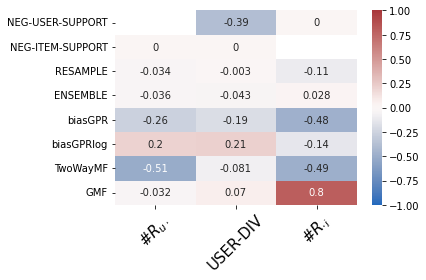

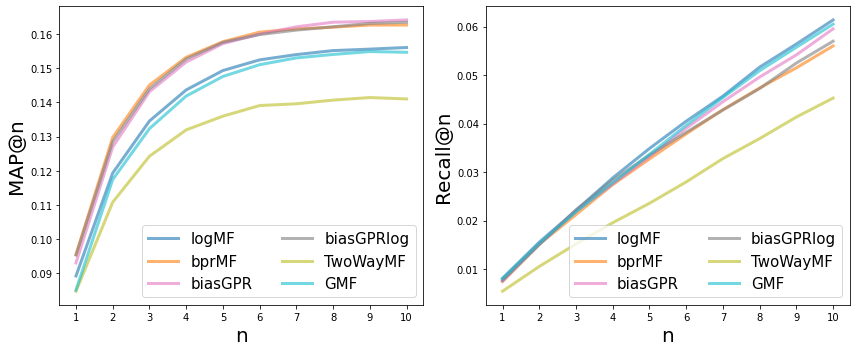

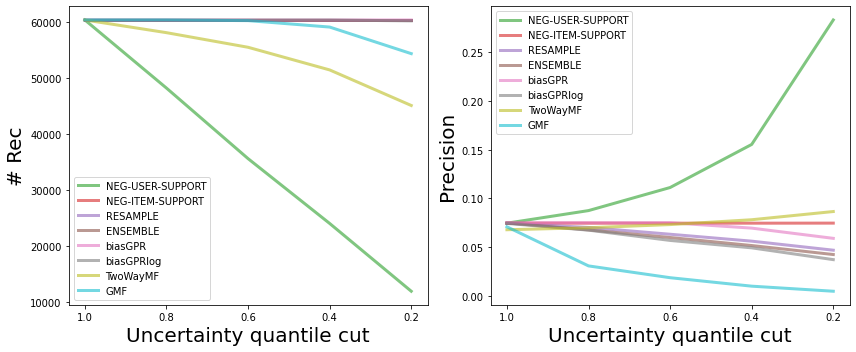

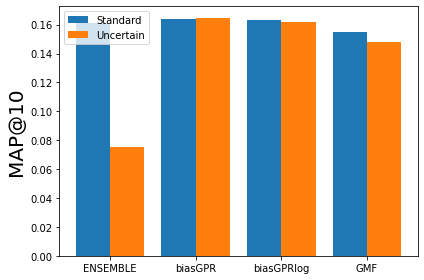

In [36]:
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['logMF', 'bprMF', 'NEG-USER-SUPPORT', 'NEG-ITEM-SUPPORT', 'RESAMPLE', 'ENSEMBLE', 'biasGPR', 'biasGPRlog', 'TwoWayMF', 'GMF']
results = dict((key, results[key]) for key in order)
colors = [c for c in list(TABLEAU_COLORS)]
colors = {k:c for k, c in zip(results, colors)}

# Rating prediction evaluation
ratings = pd.DataFrame([results[key] for key in results], index=results.keys())[['FCP', 'Concordant uncertainty', 'Discordant uncertainty']]
print(ratings)
# URI and UAC
keys = [key for key in results if key != 'logMF' and key != 'bprMF']
a = pd.DataFrame([results[key]['Rating_rec'] for key in keys], index=keys)[['URI', 'Unc_MAP_corr']]
a['URI'] = [b[-1] for b in a['URI']] 
print(a)

# Correlation plot
corr = np.empty((len(results)-2, 3))
for idx, key in enumerate(keys):
    corr[idx, 0] = results[key]['corr_usup']
    corr[idx, 1] = results[key]['corr_udiv']
    corr[idx, 2] = results[key]['corr_isup']
corr = pd.DataFrame(corr, index=keys, columns=[r'#$R_{u\cdot}$', 'USER-DIV', r'#$R_{\cdot i}$'])
corr.loc['NEG-USER-SUPPORT', r'#$R_{u\cdot}$'] = np.nan
corr.loc['NEG-ITEM-SUPPORT', r'#$R_{\cdot i}$'] = np.nan
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

# Top-K accuracy metrics
keys = ['logMF', 'bprMF', 'biasGPR', 'biasGPRlog', 'TwoWayMF', 'GMF']
f, ax = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results[key]['Rating_rec']['MAP'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results[key]['Rating_rec']['Recall'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

# Cuts
keys = [key for key in results if key != 'logMF' and key != 'bprMF']
f, ax = plt.subplots(ncols=2, figsize=(12, 5))
for key in keys:
    ax[0].plot(results[key]['Cuts']['Given'], '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(results[key]['Cuts']['Hits'] / results[key]['Cuts']['Given'], '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(range(5))
ax[0].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[0].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[0].set_ylabel('# Rec', fontsize=20)
ax[0].legend()
ax[1].set_xticks(range(5))
ax[1].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[1].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[1].set_ylabel('Precision', fontsize=20)
ax[1].legend()
f.tight_layout()
f.savefig('plots/cuts.pdf')

# Rating prediction evaluation
keys = ['ENSEMBLE', 'biasGPR', 'biasGPRlog', 'GMF']
a = {metric: {key: [results[key]['Rating_rec'][metric][-1]] + [results[key]['Uncertain_rec'][metric][-1]] 
              for key in keys} for metric in ['MAP', 'Recall']}
precision = pd.DataFrame(a['MAP'], index=['Standard', 'Uncertain']).T
f, ax = plt.subplots()
ax.bar(np.arange(len(keys))-0.2, precision['Standard'], 0.4, label='Standard')
ax.bar(np.arange(len(keys))+0.2, precision['Uncertain'], 0.4, label='Uncertain')
ax.set_xticks(np.arange(len(keys)))
ax.set_xticklabels(list(precision.index))
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend()
f.tight_layout()
f.savefig('plots/unc_rank.pdf')

In [34]:
print('Average item popularity on training: {}'.format(data.item_support[data.train[:, 1]].mean()))
print('Average item popularity on validation: {}'.format(data.item_support[data.val[:, 1]].mean()))
print('Average item popularity on test: {}'.format(data.item_support[data.test[:, 1]].mean()))

Average item popularity on training: 623.5987020563321
Average item popularity on validation: 480.97313698249513
Average item popularity on test: 430.13533105632047


- [X] Check if all models in explicit case are outputting uncertainty properly. 

- [X] BeMF should not borrow the uncertainty metric from the rating case into the recommendation case / BeMF could do simply 1 - P(r > 4) as uncertainty. This would make uncertainty inversely proportional to relevance, but does the absolute values of the numbers still add something?

- [X] Also think about the absolute uncertainty numbers for the other models. Vanilla RRI might be the answer.

- [X] Check giovanni's paper experiment description (especially the early stopping part). There, they use MAP for early stopping as well, which removes the need of negative samples but increase the computational cost. They do validation check every 5 epochs. Their batch size also varies and is sometimes really small, which means that 5 epochs may consist of lots and lots of updates.

## RRI formulation

- Original: $$ \frac{\rho_{ui} - \bar{\rho}}{\sigma_\rho} $$
- Ours: $$ \frac{\rho_{ui} - \bar{\rho_u}}{\sigma_{\rho_u}} $$

We aknowledged that the original form has the problem of penalizing correct recommendations every time that their uncertainty is higher than the average uncertainty. For this reason we changed to the user based form, in which the uncertainties are compared to the user average uncertainty, and therefore a penalty to the RRI value occurs only if the uncertainty of the correct recommendation is higher than the average uncertainty for the user.

Nevertheless, our formulation does not analyze the recommendation in a cross-user aspect. Ideally, if uncertainty is well defined, than we want the recommendation hits to a user to be those with the lowest uncertainty among the recommendations to that user, and also the most precise recommendation sets to be given to the user with the lowest average uncertaity.